In [45]:
%matplotlib inline
import os
import cv2
import numpy as np
from copy import deepcopy
from PIL import Image
import matplotlib.pyplot as plt
from scripts.methods.groundtruth import GroundTruth # import GroundTruth OK
from scripts.methods.model.model import ClothEdgeModel # import ClothEdgeModel OK
from my_utils import *
from datetime import datetime
from sklearn.neighbors import KDTree

In [46]:
class NetworkGraspSelector:
    """
    Grasp Selector using the output of the cloth region segmentation network
    """
    def __init__(self, grasp_point_method, grasp_angle_method, grasp_target):
        self.grasp_point_method = grasp_point_method
        self.grasp_angle_method = grasp_angle_method
        self.grasp_pt = None
        self.grasp_target= grasp_target

    # seems not used in this project
    def sample_grasp(self, segmentation, pred):
        """Takes a 2D array prop to prob as input and sample grasp point."""
        # Filter for outer edge points w/o overlap only
        im_height, im_width, _ = segmentation.shape
        outer_edges_mask = np.zeros((im_height, im_width))
        outer_edges_mask[segmentation[:,:,1]==255] = 1

        var_map = outer_edges_mask*pred[:, :, -1]
        pvec = var_map.ravel()/np.sum(var_map) # flatten and normalize to PMF
        idx = np.random.choice(a=range(pvec.shape[0]), p=pvec)
        y,x = np.unravel_index(idx, var_map.shape)

        im = (var_map / var_map.max() * 255).astype(np.uint8)
        self.pub.publish(self.bridge.cv2_to_imgmsg(im, encoding="mono8"))

        return np.array([y,x])

    def select_grasp(self, rgb, corners, outer_edges, inner_edges, pred, retries=1, num_neighbour=8):
        impred = np.zeros((corners.shape[0], corners.shape[1], 3), dtype=np.uint8)
        impred[:, :, 0] += corners
        impred[:, :, 1] += outer_edges
        impred[:, :, 2] += inner_edges

        idxs = np.where(corners == 255)
        corners[:] = 1
        corners[idxs] = 0
        idxs = np.where(outer_edges == 255)
        outer_edges[:] = 1
        outer_edges[idxs] = 0
        idxs = np.where(inner_edges == 255)
        inner_edges[:] = 1
        inner_edges[idxs] = 0

        # Choose pixel in pred to grasp
        grasp_target = self.grasp_target
        channel = 1 if grasp_target == 'edges' else 0
        indices = np.where(impred[:, :, channel] == 255) # outer_edge
        if len(indices[0]) == 0:
            print("No graspable pixels detected")
            return 0, 0, 0, 0, 0

        if self.grasp_point_method == 'policy':
            outer_edges = deepcopy(pred[:, :, 1])
            mask = np.zeros_like(outer_edges)
            mask[outer_edges > 0.9] = 1
            var = deepcopy(pred[:, :, -1])
            var *= mask

            pvar = var.ravel()/np.sum(var) # flatten and normalize to PMF
            idx = np.random.choice(a=range(pvar.shape[0]), p=pvar)
            y, x = np.unravel_index(idx, var.shape)

            # 好像没有用到var_map
            var_map = (var / var.max() * 255.).astype('uint8')
            # self.pub.publish(self.bridge.cv2_to_imgmsg(var_map))
        else: 
            if self.grasp_point_method == 'manual':
                # Only works once due to rendering issues, need to restart service
                print("Manually choosing grasp point")
                wintitle = 'Choose grasp point'
                cv2.namedWindow(wintitle)
                cv2.setMouseCallback(wintitle, self.winclicked)
                cv2.imshow(wintitle, impred)
                cv2.waitKey(0)
                y, x = self.grasp_pt
            elif self.grasp_point_method == 'random':
                idx = np.random.choice(range(len(indices[0])))
                y = indices[0][idx]
                x = indices[1][idx]
            elif self.grasp_point_method == 'confidence':
                # Filter out ambiguous points
                # impred:[im_height, im_width, 3] -> corner, outer edge, inner edge predictions
                segmentation = deepcopy(impred)
                im_height, im_width, _ = segmentation.shape
                segmentation[np.logical_and(impred[:,:,1]==255, impred[:,:,2]==255),2] = 0
                segmentation[np.logical_and(impred[:,:,1]==255, impred[:,:,2]==255),1] = 0

                inner_edges_filt = np.ones((im_height, im_width))
                inner_edges_filt[segmentation[:,:,2]==255] = 0

                outer_edges_filt = np.ones((im_height, im_width))
                outer_edges_filt[segmentation[:,:,1]==255] = 0

                # Get outer-inner edge correspondence
                xx, yy =  np.meshgrid([x for x in range(im_width)],
                                    [y for y in range(im_height)])

                if grasp_target == 'edges':
                    xx_o = xx[segmentation[:,:,1]==255]
                    yy_o = yy[segmentation[:,:,1]==255]
                else:
                    xx_o = xx[segmentation[:,:,0]==255]
                    yy_o = yy[segmentation[:,:,0]==255]

                xx_i = xx[segmentation[:,:,2]==255]
                yy_i = yy[segmentation[:,:,2]==255]

                _, lbl = cv2.distanceTransformWithLabels(inner_edges_filt.astype(np.uint8), cv2.DIST_L2, 5, labelType=cv2.DIST_LABEL_PIXEL)

                loc = np.where(inner_edges_filt==0)
                xx_inner = loc[1]
                yy_inner = loc[0]
                label_to_loc = [[0,0]]

                for j in range(len(yy_inner)):
                    label_to_loc.append([yy_inner[j],xx_inner[j]])

                label_to_loc = np.array(label_to_loc)
                direction = label_to_loc[lbl]
                # Calculate distance to the closest inner edge point for every pixel in the image
                distance = np.zeros(direction.shape)

                distance[:,:,0] = np.abs(direction[:,:,0]-yy)
                distance[:,:,1] = np.abs(direction[:,:,1]-xx)
                
                # Normalize distance vectors
                mag = np.linalg.norm([distance[:,:,0],distance[:,:,1]],axis = 0)+0.00001
                distance[:,:,0] = distance[:,:,0]/mag
                distance[:,:,1] = distance[:,:,1]/mag

                # Get distances of outer edges
                distance_o = distance[segmentation[:,:,1]==255,:]

                # Get outer edge neighbors of each outer edge point
                num_neighbour = 100

                # For every outer edge point, find its closest K neighbours 
                tree = KDTree(np.vstack([xx_o,yy_o]).T, leaf_size=2)
                dist, ind = tree.query(np.vstack([xx_o,yy_o]).T, k=num_neighbour)
                
                xx_neighbours = distance_o[ind][:,:,1]
                yy_neighbours = distance_o[ind][:,:,0]
                xx_var = np.var(xx_neighbours,axis = 1)
                yy_var = np.var(yy_neighbours,axis = 1)
                var = xx_var+yy_var
                var = (var-np.min(var))/(np.max(var)-np.min(var))
                
                # Choose min var point
                var_min = np.min(var)
                min_idxs = np.where(var == var_min)[0]
                print("Number of min var indices:", len(min_idxs))
                idx = np.random.choice(min_idxs)
                x = xx_o[idx]
                y = yy_o[idx]

                # myplot(impred, xx_o, yy_o, var, outer_edges_filt, xx, yy, segmentation)
                ENABLE_PLOT = True
                if ENABLE_PLOT:
                    impred2 = deepcopy(segmentation)
                    impred2[:, :, 0] = 0 # 将第一个维度全部设为0
                    fig = plt.figure()
                    ax = plt.subplot(121)
                    empty = np.zeros(impred.shape)
                    ax.imshow(empty) # 将empty显示在第一个子图中,这里呈现一个白色的矩形
                    scat = ax.scatter(xx_o, yy_o, c=var, cmap='RdBu', s=3)
                    # scat = ax.scatter(xx_i, yy_i, c=var, cmap='RdBu', s=3)
                    plt.colorbar(scat)
                    ax.scatter(x, y, c='blue', alpha=0.7)
                    ax = plt.subplot(122)
                    ax.imshow(impred2)
                    # plt.show()
                    
                    # for arrow plot
                    # factor = 2
                    # xx = xx[outer_edges_filt==0]
                    # yy = yy[outer_edges_filt==0]
                    # direction_o = direction[segmentation[:,:,1]==255,:]
                    # ax.quiver(xx_o[::factor],yy_o[::factor],direction_o[::factor,1]-xx_o[::factor],-direction_o[::factor,0]+yy_o[::factor], color='white', scale=1, scale_units='x')

                    base_path = "/home/chimy/projects/biyesheji/cloth-segmentation/service_without_ROS_test/grasp_output"
                    tstamp = datetime.now().strftime("%d_%m_%Y_%H:%M:%S")
                    tstamp_path = os.path.join(base_path, tstamp)
                    os.makedirs(tstamp_path)

                    fig.canvas.draw()
                    w,h = fig.canvas.get_width_height()
                    buf = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h, w, 3)
                    np.save(os.path.join(tstamp_path, "plot_%s" % tstamp), buf)
                    
                    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
                    cv2.imwrite(os.path.join(tstamp_path, "rgb_%s.png" % tstamp), rgb)
                    plt.savefig(os.path.join(tstamp_path, 'uncertainty_%s.png' % tstamp))
                    plt.show()
            else:
                raise NotImplementedError

        print("Grasp point method: ", self.grasp_point_method)
        print("Choose pixel x:", x, "y:", y)

        # Get outer_pt and inner_pt for computing grasp angle
        if self.grasp_angle_method == 'inneredge':
            # 计算内边缘到当前像素点的最短距离,并返回距离最近的inner_edge的像素坐标
            
            # 返回两个矩阵,temp记录每个像素点到离他最近的inner_edge的距离, lbl记录每个像素点距离最近的边缘的标记值
            temp, lbl = cv2.distanceTransformWithLabels(inner_edges.astype(np.uint8), cv2.DIST_L2, 5, labelType=cv2.DIST_LABEL_PIXEL)
            # 获取所有inner_edges==0的x和y值
            loc = np.where(inner_edges==0)
            xx_inner = loc[1]
            yy_inner = loc[0]

            # change
            label_to_loc = list(zip(yy_inner, xx_inner))
            # label_to_loc = zip(yy_inner, xx_inner) # AttributeError: 'zip' object has no attribute 'insert'
            label_to_loc.insert(0, (0, 0)) # 1-indexed

            label_to_loc = np.array(label_to_loc)
            direction = label_to_loc[lbl]
            outer_pt = np.array([y, x])
            inner_pt = direction[y, x]
        elif self.grasp_angle_method == 'center': # 貌似outer_pt是随机生成的,inner_pt是由物体的包围框计算,可以看作物体的几何中心
            # 随机抽取一个像素作为抓取点的位置
            idx = np.random.choice(range(len(indices[0])))
            y = indices[0][idx]
            x = indices[1][idx]

            # get bbox
            bbox = deepcopy(outer_edges) if grasp_target == 'edges' else deepcopy(corners)
            
            # idxs提取掩码中非0像素点,生成一个全0的空白掩码,将idxs对应的坐标位置的像素值赋1,（将物体从边缘或者角点的形状转换成矩形）
            idxs = np.where(bbox == 0)
            bbox[:] = 0
            bbox[idxs] = 1

            # 计算bbox的尺寸和位置
            pbox = cv2.boundingRect(bbox)
            center_x = pbox[0] + 0.5*pbox[2]
            center_y = pbox[1] + 0.5*pbox[3]
            outer_pt = np.array([y, x])
            inner_pt = np.array([center_y, center_x])
        else:
            raise NotImplementedError

        # count the angle
        v = inner_pt - outer_pt
        magn = np.linalg.norm(v)

        if magn == 0:
            error_msg = "magnitude is zero for %d samples" % retries
            print(error_msg)

        unitv = v / magn
        originv = [0, 1] # [y, x]
        angle = np.arccos(np.dot(unitv, originv))

        if v[0] < 0:
            angle = -angle
        
        return outer_pt[0], outer_pt[1], angle, inner_pt[0], inner_pt[1] 

In [47]:
class EdgeDetector:
    def __init__(self, detection_method, crop_dims, datapath):
        self.detection_method = detection_method
        self.datapath = datapath
        self._init_model(crop_dims)
        self.depth_im = None
        self.rgb_im = None
        print("finish init")

    def _init_model(self, crop_dims):
        if self.detection_method == 'groundtruth':
            self.crop_dims = crop_dims
            self.model = GroundTruth(self.crop_dims)
        elif self.detection_method == 'network':
            self.crop_dims = crop_dims
            grasp_angle_method = 'inneredge'
            
            # grasp_angle_method 表示程序在计算抓取角度时要使用的方法
            # 如果 grasp_angle_method 为 'predict'，说明程序要使用的模型是用于预测抓取角度的模型，
            # 因此 model_path 参数将被替换为 model_angle_path 参数，即程序将使用不同的模型。
            # 否则，model_path 参数保持不变，程序将使用默认的模型。
            # 因此，这行代码的作用是根据 grasp_angle_method 的值获取正确的模型路径，并将其保存在 model_path 变量中。
            
            model_path = "/home/chimy/old_projects/cloth-segmentation-main/runspath/pretrained_weights"
            self.model = ClothEdgeModel(self.crop_dims, grasp_angle_method, model_path)

    def detect_edge(self, i):
        try:
            rgb_im = Image.open(os.path.join(self.datapath, "rgb_%d.png" % i))
            depth_im = np.load(os.path.join(self.datapath, "%d_depth.npy" % i))
            max_d = np.nanmax(depth_im)
            depth_im[np.isnan(depth_im)] = max_d
            print(os.path.join(self.datapath, "%d_depth.npy" % i))
        except FileNotFoundError:
            print("File not found")
        except:
            print("Failed to read file")
        
        # Prevents NaN from causing errors in image processing
        self.depth_im = np.nan_to_num(depth_im)
        self.rgb_im = cv2.imread(os.path.join(self.datapath, "rgb_%d.png" % i))

        # _server_cb content
        print("Received cloth detection request")

        rgb_im = deepcopy(self.rgb_im)  
        depth_im = deepcopy(self.depth_im)

        # plt.figure(dpi=300)
        # plt.subplot(121)
        # plt.title("rgb_im")
        # plt.imshow(rgb_im)
        # plt.axis("off")
        # plt.subplot(122)
        # plt.title("depth_im")
        # plt.imshow(depth_im)
        # plt.axis("off")
        # plt.show()

        response = DetectEdgeResponse()
        response.rgb_im = self.rgb_im
        response.depth_im = self.depth_im
        # get response and save images
        if self.detection_method == 'groundtruth':
            pred = self.model.predict(rgb_im)
            # pred = self.model.predict(rgb_im)
            response.prediction = pred
        elif self.detection_method == 'network':
            self.model.update() # Check if model needs to be reloaded
            print("depth_image.shape: ", depth_im.shape)
            # all numpy.ndarray
            corners, outer_edges, inner_edges, pred = self.model.predict(depth_im)
            print("add time later")
            print("corners.shape:", corners.shape)
            print("outer_edges.shape:", outer_edges.shape)
            print("inner_edges.shape:",inner_edges.shape)
            print("pred.shape:",pred.shape)

            # save prediction 
            corners_img = get_depth_img(corners)
            cv2.imwrite('corners_img.png', corners_img)
            outer_img = get_depth_img(outer_edges)
            cv2.imwrite('outer_img.png', outer_img)
            inner_img = get_depth_img(inner_edges)
            cv2.imwrite('inner_img.png', inner_img)
            pred_img = get_depth_img(pred)
            cv2.imwrite('pred_img.png', pred_img)

        response.prediction = pred
        response.corners = corners
        response.outer_edges = outer_edges
        response.inner_edges = inner_edges
        
        # TYPE_TEST = True
        # if TYPE_TEST:
        #     print("response.prediction.type:",response.prediction.type)
        #     print("response.corners.type:",response.corners.type)
        #     print("response.outer_edges.type:",response.outer_edges.type)
        #     print("response.inner_edges.type:",response.inner_edges.type)
        return response

    def run(self, img_index):
        # set self.depth_im & self.rgb_im, 
        # img_index: dataset image index
        index = img_index

        # DetectEdgeResponse
        prediction = self.detect_edge(index)
        
        return prediction

In [48]:
class GraspSelector:
    def __init__(self, detection_method, grasp_point_method, grasp_angle_method, img_prediction, grasp_target):
        self.detection_method = detection_method
        self.grasp_point_method = grasp_point_method
        self.grasp_angle_method = grasp_angle_method
        self.img_prediction = img_prediction
        self.grasp_target = grasp_target
        self._init_selector()

    def _init_selector(self):
        # self.selector = XXX
        if self.detection_method == 'groundtruth':
            print("Not define GroundTruthSelector")
            # self.selector = GroundTruthSelector()
        elif self.detection_method == 'network':
            self.selector = NetworkGraspSelector(self.grasp_point_method, self.grasp_angle_method, self.grasp_target)
        else:
            raise NotImplementedError
        print("Success init selector.")
        return
    
    def run(self):
        img_prediction = self.img_prediction
        inner_py = None
        inner_px = None

        if self.detection_method == 'groundtruth':
            pred = deepcopy(img_prediction.prediction)
            py, px, angle, inner_py, inner_px, var, angle_x, angle_y = self.selector.select_grasp(pred)
        elif self.detection_method == 'network':
            corners = deepcopy(img_prediction.corners)
            outer_edges = deepcopy(img_prediction.outer_edges)
            inner_edges = deepcopy(img_prediction.inner_edges)
            rgb = deepcopy(img_prediction.rgb_im)
            pred = deepcopy(img_prediction.prediction)
            py, px, angle, inner_py, inner_px = self.selector.select_grasp(rgb, corners, outer_edges, inner_edges, pred)
        else:
            prediction = deepcopy(img_prediction.prediction)
            py, px, angle = self.selector.select_grasp(prediction)
            print(py, px, angle)

        response = SelectGraspResponse()
        response.py = py
        response.px = px
        response.angle = angle
        # print inner_px & inner_py
        if inner_py != None and inner_px != None:
            response.inner_py = inner_py
            response.inner_px = inner_px
        if self.detection_method == 'groundtruth' and px != 0:
            response.var = var.flatten()
            response.angle_x = angle_x.flatten()
            response.angle_y = angle_y.flatten()

        print("Get grasp selection response:")
        print('{:<10} {:<5} {:<10} {:<5}'.format("px:", px, "py:", py))
        print('\033[32m' + '{:<10} {} '.format("angle:", angle) + '\033[0m')
        print('{:<10} {:<5} {:<10} {:<5}'.format("inner_px:", inner_px, "inner_py:", inner_py))

        # self.selector.plot(pred, px, py, var, None, inner_px, inner_py, prediction.prediction)
        return response

Begin detect_edge process
finish init
/home/chimy/projects/biyesheji/data_painted_towel/10_depth.npy
Received cloth detection request
depth_image.shape:  (255, 243)
In model.predict process, at first, image.shape:  (255, 243)
In model.predict process, after crop, image.shape:  (255, 243)
add time later
corners.shape: (255, 243)
outer_edges.shape: (255, 243)
inner_edges.shape: (255, 243)
pred.shape: (255, 243, 3)
End detect_edge process
prediction.rgb_im.shape:  (255, 243, 3)
prediction.depth_im.shape: (255, 243)
prediction.prediction.shape: (255, 243, 3)
prediction.corners.shape: (255, 243)
prediction.outer_edges.shape: (255, 243)
prediction.inner_edges.shape: (255, 243)
Begin select_grasp process
Success init selector.
Number of min var indices: 1


ValueError: 'c' argument has 703 elements, which is inconsistent with 'x' and 'y' with size 1787.

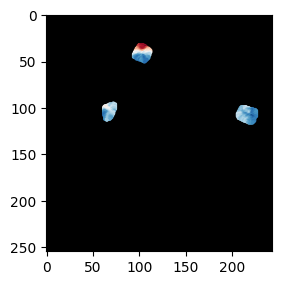

In [49]:
def detect_edge():
    detection_method = 'network'
    datapath = "/home/chimy/projects/biyesheji/data_painted_towel"
    crop_dims = [180, 650, 450, 900, 2] # seems not used yet
    img_index = 10

    e = EdgeDetector(detection_method, crop_dims, datapath)
    prediction = e.run(img_index)
    return prediction

def select_grasp(prediction):
    detection_method = "network"
    # Option: random, manual, confidence, policy
    grasp_point_method = "confidence"
    # Option: predict没有写?, inneredge, center
    grasp_angle_method = "inneredge"
    # Option: corner, edge
    grasp_target = "edge"

    g = GraspSelector(detection_method, grasp_point_method, grasp_angle_method, prediction, grasp_target)
    grasp = g.run()
    return grasp

if __name__ == '__main__':
    print('\033[32m' + '==========================================' + '\033[0m')
    print('\033[32m' + 'Begin detect_edge process' + '\033[0m')
    prediction = detect_edge()
    print('\033[32m' + 'End detect_edge process' + '\033[0m')
    print('\033[32m' + '==========================================' + '\033[0m')

    # print prediction shape 
    ENBALE_PREDICTION_SHAPE_TEST = True
    if ENBALE_PREDICTION_SHAPE_TEST:
        print('{:<25} {}'.format("prediction.rgb_im.shape:", prediction.rgb_im.shape))
        print('{:<25} {}'.format("prediction.depth_im.shape:", prediction.depth_im.shape))
        print('{:<25} {}'.format("prediction.prediction.shape:", prediction.prediction.shape))
        print('{:<25} {}'.format("prediction.corners.shape:", prediction.corners.shape))
        print('{:<25} {}'.format("prediction.outer_edges.shape:", prediction.outer_edges.shape))
        print('{:<25} {}'.format("prediction.inner_edges.shape:", prediction.inner_edges.shape))

    print('\033[32m' + '==========================================' + '\033[0m')
    print('\033[32m' + 'Begin select_grasp process' + '\033[0m')
    grasp = select_grasp(prediction)
    print('\033[32m' + 'End select_grasp process' + '\033[0m')
    print('\033[32m' + '==========================================' + '\033[0m')